**Data description:**
- Data is downloaded from [Quandl](https://www.quandl.com/data/NS1-FinSentS-Web-News-Sentiment)
- Sentiment: Sentiment scores are a measure of bullishness and bearishness of equity prices calculated as statistical index of positivity and negitivity of news corpus. Scores are defined on a scale of -5 to 5 where -5 and 5 are extremely bearish and bullish indicators respectively.
- Buzz: Buzz scores are normalized values of change in standard deviations of periodic news volume. Buzz scores reflect a sharp change in news volume thus serving as a risk alert indicator. Defined on a scale of 1-10 high buzz score reflects higher volatility.

**Steps**

Sentiment data is the opinion of public towards the stock, therefore, this data may reveal some information about the trend of stock price. In this kernel, the following steps are performed to analyze the sentiment data as well as the interaction between sentiment information and stock price of the period of 4 years from 2013-01-01 to 2016-12-31:

1. Load data
2. Show basic descriptive statistics for each columns
3. Show the interaction between sentiment and price

In [1]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import pickle
import os

pylab.rcParams['figure.figsize'] = 16, 12 

%matplotlib inline

In [2]:
quandl.ApiConfig.api_key = 'o-yXuCnVqzcxKcUzc6vb'

# Load data

In [3]:
start = '2013-01-01'
end = '2016-12-31'

In [4]:
data = quandl.get("NS1/AAPL_US", start_date=start, end_date=end)

In [5]:
data.head()

,Sentiment,Sentiment High,Sentiment Low,News Volume,News Buzz
Date,,,,,
2013-01-01,1.0,5.0,-4.0,48.0,10.0
2013-01-02,-1.0,4.0,-5.0,53.0,10.0
2013-01-03,-1.0,4.0,-5.0,44.0,10.0
2013-01-04,1.0,5.0,-3.0,59.0,10.0
2013-01-05,4.0,4.0,4.0,2.0,5.0


In [6]:
data.shape

(1402, 5)

In [7]:
#check missing values
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
News Buzz,0,0.0
News Volume,0,0.0
Sentiment Low,0,0.0
Sentiment High,0,0.0
Sentiment,0,0.0


# Show basic descriptive statistics for each columns

In [8]:
data['Sentiment'].describe()

count    1402.000000
mean       -0.176177
std         1.627188
min        -5.000000
25%        -1.000000
50%        -1.000000
75%         1.000000
max         5.000000
Name: Sentiment, dtype: float64

In [9]:
data['News Volume'].describe()

count    1402.000000
mean       49.905136
std        46.452361
min         0.000000
25%        10.000000
50%        41.500000
75%        73.000000
max       291.000000
Name: News Volume, dtype: float64

In [10]:
data['News Buzz'].describe()

count    1402.000000
mean        9.136234
std        18.601209
min         0.000000
25%         2.000000
50%         5.000000
75%         8.000000
max       201.000000
Name: News Buzz, dtype: float64

In [11]:
def plot_data(df, title="Sentiment scores", save_figure=False, file_name="./default.png"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    plt.figure(figsize=(25, 3))
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Sentiment")
    if save_figure:
        plt.savefig(file_name)
    plt.show()

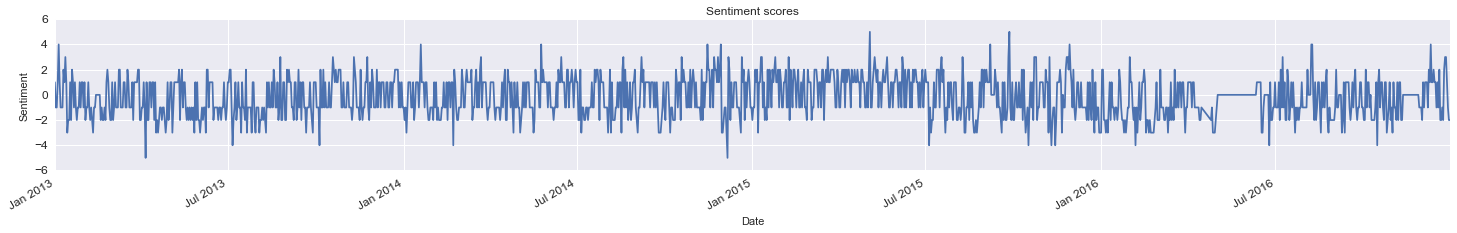

In [12]:
plot_data(data['Sentiment'])

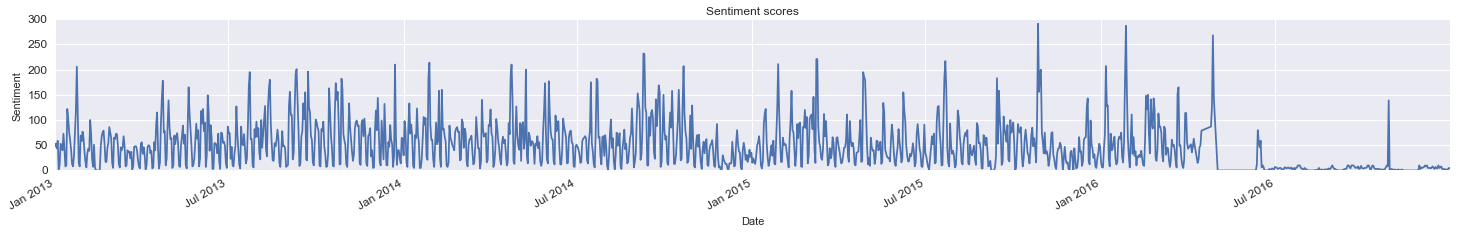

In [13]:
plot_data(data['News Volume'])

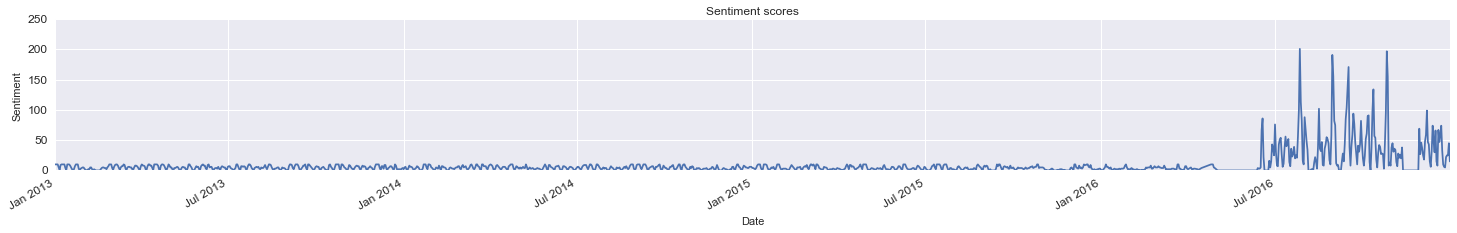

In [14]:
plot_data(data['News Buzz'])

The market sentiment is negative towards APPL

# Interaction

As can be seen, the shape of sentiment data (1399) is different from the shape of stock price (1008). This comes from the fact that the stock prices are the prices in trading days while the sentiment can be recorded every single day over the years.

Here, the objective is to observe the relationship between sentiment and price, the data of these information should be merged. Because of the different shape, the merging steps will be:
- Concat and fill nan with missing prices
- Fill missing prices with the price of the previous day

In [15]:
with open("data/compiled_data.pkl", "rb") as f:
    joined_price_data = pickle.load(f)

In [16]:
stock_price = pd.DataFrame({'Price':joined_price_data['AAPL'].values}, index = joined_price_data.index)

In [17]:
stock_price.head()

,Price
Date,
2013-01-02,71.777153
2013-01-03,70.870627
2013-01-04,68.897072
2013-01-07,68.491795
2013-01-08,68.676131


In [18]:
stock_price.shape

(1008, 1)

In [19]:
data.shape

(1402, 5)

In [20]:
full_data = pd.concat([stock_price, data], axis=1, join_axes=[data.index])

In [21]:
total = full_data.isnull().sum().sort_values(ascending=False)
percent = (full_data.isnull().sum()/full_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Price,427,0.304565
News Buzz,0,0.000000
News Volume,0,0.000000
Sentiment Low,0,0.000000
Sentiment High,0,0.000000
Sentiment,0,0.000000


In [22]:
def nanImpute(df):
    df['Price'][0] = df['Price'][1]
    for index, elem in enumerate(df['Price']):
        if pd.isnull(elem):
            df['Price'][index] = df['Price'][index-1]
    return df

In [23]:
#full_data.head()

In [24]:
full_data = nanImpute(full_data)
percentage_change = full_data[['Price', 'Sentiment', 'News Buzz']].pct_change()

In [25]:
#full_data.head()

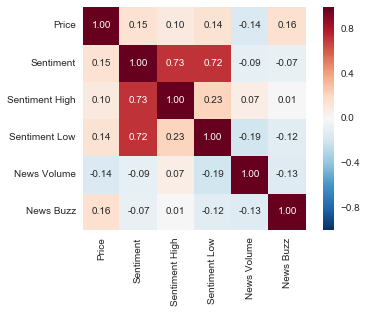

In [26]:
C = full_data.corr()
hm = sns.heatmap(C, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.savefig('figures/correlation.png')
plt.show()

In [27]:
C = percentage_change.corr()
C

,Price,Sentiment,News Buzz
Price,1.000000,-0.058611,0.057407
Sentiment,-0.058611,1.000000,-0.052863
News Buzz,0.057407,-0.052863,1.000000


In [28]:
def plot_interaction(df, save_figure=False, file_name="./default.png"):
    '''Plots two variables with different scales'''
    #fig = plt.figure(figsize=(20, 10), facecolor='w', dpi=100)
    fig, ax1 = plt.subplots()
    ax1.plot(df.index, df['Price'], 'b-')
    ax1.set_xlabel('Timeline')
    
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Stock price', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(df.index, df['Sentiment'], 'r-')
    ax2.set_ylabel('Sentiment', color='r')
    ax2.tick_params('y', colors='r')
    
    if save_figure:
        plt.savefig(file_name)
    plt.show()

In [29]:
sub_full_data = full_data.ix['2014-01-01': '2014-06-30']
sub_percentage_change = percentage_change.ix['2014-01-01': '2014-06-30']

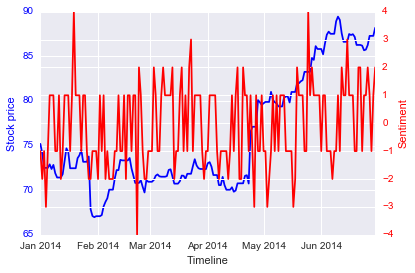

In [30]:
plot_interaction(sub_full_data, save_figure=True, file_name='figures/sentiment_price_6month.png')

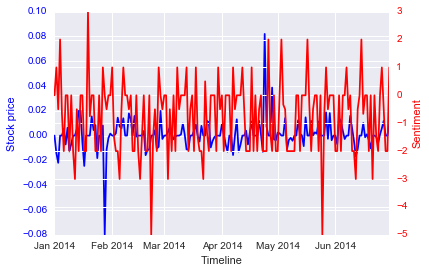

In [31]:
plot_interaction(sub_percentage_change, save_figure=True, file_name='figures/sentiment_price_change_6month.png')

The sentiment doesn't really reveal the information of stock price of AAPL